In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def simulate_system(mu, X0):
    p, v = simulate_phase_portrait('vanderpol', t, X0, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

# For initial conditions, sample a rectangle uniformly

In [4]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [20]:
n_steps=10
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i])
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Display state spaces under four different parameter conditions

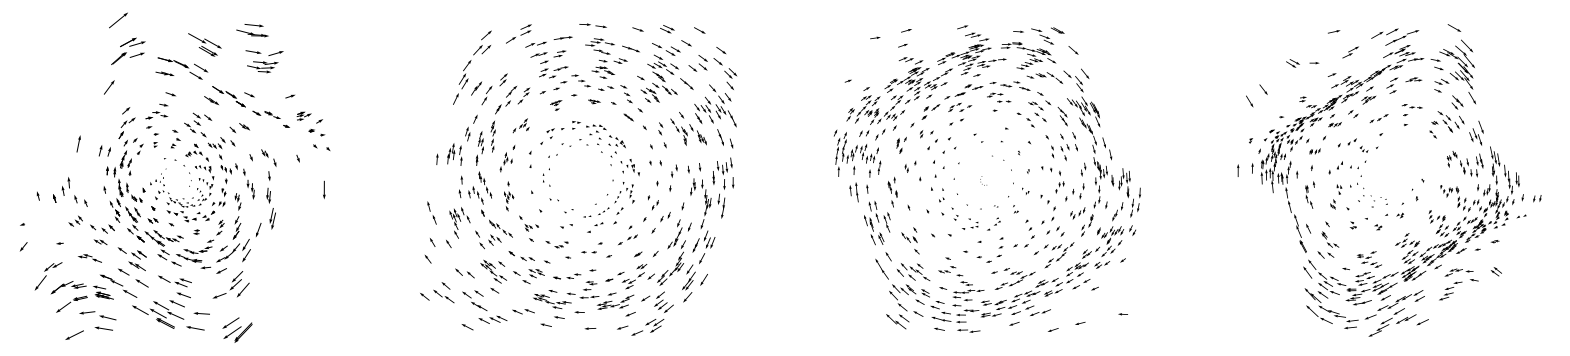

In [6]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0])
plot_phase_portrait(pos[n_steps//2-1], vel[n_steps//2-1], ax[1])
plot_phase_portrait(pos[n_steps//2+1], vel[n_steps//2+1], ax[2])
plot_phase_portrait(pos[-1], vel[-1], ax[3])

# Train network

In [7]:
k=15

data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=k, stop_crit=0.02)

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

par = {'batch_size': 64, #batch size
       'epochs': 40, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'inner_product_features': True,
       'autoencoder': False
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 64
epochs : 40
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
inner_product_features : True
autoencoder : False
lr : 0.001
vector : False
diffusion : None
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 30
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  209
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 1.3812, Validation loss: 1.3716
Epoch: 2, Training loss: 1.3560, Validation loss: 1.3240
Epoch: 3, Training loss: 1.2688, Validation loss: 1.1973
Epoch: 4, Training loss: 1.1895, Validation loss: 1.1758
Epoch: 5, Training loss: 1.1875, Validation loss: 1.1977
Epoch: 6, Training loss: 1.1639, Validation loss: 1.1267
Epoch: 7, Training loss: 1.1529, Validation loss: 1.1323
Epoch: 8, Training loss: 1.1

# Create embeddings

In [9]:
data = model.evaluate(data)
n_clusters=30
data = postprocessing(data, n_clusters=n_clusters)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Performed umap embedding on embedded results.


Performed MDS embedding on embedded results.


<AxesSubplot:>

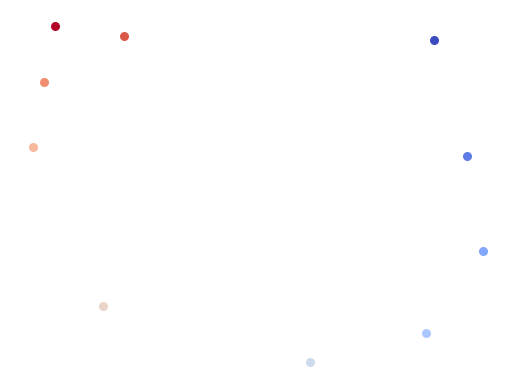

In [10]:
emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, s=30, alpha=1)

# Distance matrix

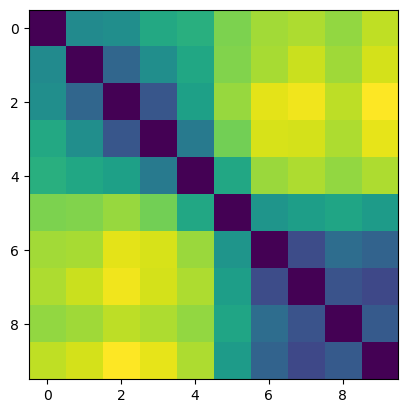

In [12]:
plt.imshow(data.dist)

# Cluster and visualise embedding

<AxesSubplot:>

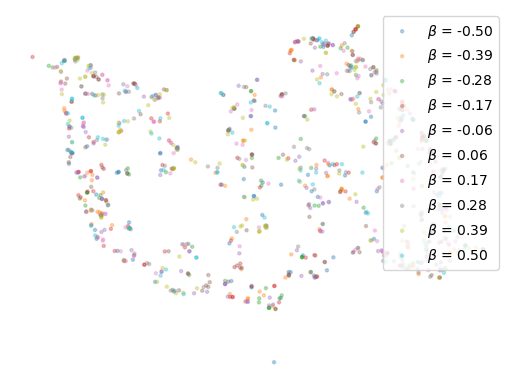

In [16]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(data.emb_2d, data.y.numpy(), titles=titles)

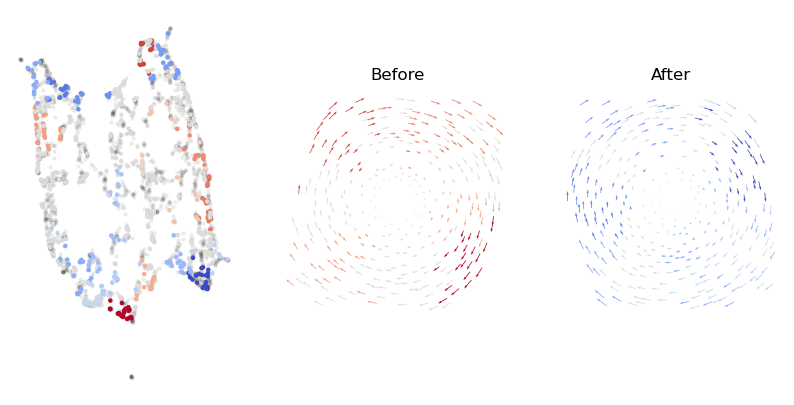

In [17]:
compare_attractors(data, (4,5))

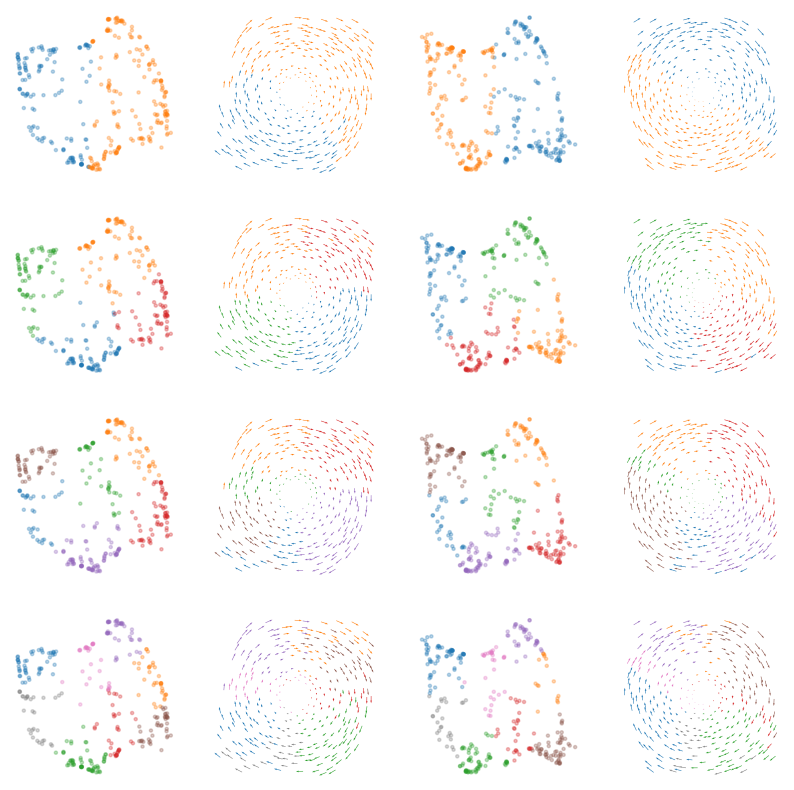

In [19]:
n_clusters=[2,4,6,8]
fig, ax = plt.subplots(len(n_clusters),4, figsize=(10,10))
slices=data._slice_dict['x']

def plot_embedding(data, ax, slices, i, n_clusters=2):
    s = range(slices[i], slices[i+1])
    clusters = geometry.cluster(data.emb_2d, cluster_typ='kmeans', n_clusters=n_clusters, seed=0)
    plotting.embedding(data.emb_2d[s], clusters['labels'][s], ax=ax[0])
    plot_phase_portrait(data.pos[s], data.x[s], ax[1], node_feature=clusters['labels'][s])

snapshot=4
for i, n in enumerate(n_clusters):
    plot_embedding(data, ax[:,:2][i], slices, snapshot, n_clusters=n)
    
snapshot=5
for i, n in enumerate(n_clusters):
    plot_embedding(data, ax[:,2:][i], slices, snapshot, n_clusters=n)